<a href="https://colab.research.google.com/github/p132588/Airlines-on-time-performance-analysis/blob/main/Airlines_on_time_performance_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Airlines on-time performance analysis**

## **Dataset introduction**

**Data Sources**：https://www.kaggle.com/datasets/wenxingdi/data-expo-2009-airline-on-time-data/data?select=1993.csv

*This analysis only takes the data of 2006 as an example

**Analyze goals：**

• What are the optimal times of day, days of the week, and times of the year for minimizing flight delays?

• What are the primary factors contributing to flight delays?

• What factors predominantly lead to flight cancellations?

• Which flight experiences the most frequent and significant delays and cancellations?

**Variable explanation:**

**2006.csv**

* Year: years -2006

* Month: month, range is 1-12.

* DayofMonth: the day of the month, the range is 1-31.

* DayOfWeek: day of the week, ranging from 1 (Monday) to 7 (Sunday).

* DepTime: actual departure time

* CRSDepTime: planned departure time

* ArrTime: actual arrival time

* CRSArrTime: planned arrival time

* UniqueCarrier: airline code

* FlightNum: flight number

* TailNum: aircraft tail number

* ActualElapsedTime: actual flight time

* CRSElapsedTime: planned flight time

* AirTime: planned flight time Flight time in minutes.

* ArrDelay: the difference between scheduled and actual departure time, in minutes. Early departures are shown as negative numbers.

* DepDelay: departure delay time in minutes

* Origin: the IATA code of the originating airport.

* Dest: the IATA code of the destination airport.

* Distance: the distance between airports in miles.

* TaxiIn: the time it takes for the aircraft to taxi to the parking space after landing

* TaxiOut: the time it takes for an aircraft to taxi from the parking lot to the runway

* Cancelled: whether the flight was cancelled. The value of this field is 1 if the flight is cancelled, 0 otherwise

* CancellationCode: reason for flight cancellation. This is a code indicating the specific reason for the cancellation

* Diverted: whether the flight has changed its scheduled destination. The value of this field is 1 if the flight was diverted, 0 otherwise

* CarrierDelay: delay time caused by airlines

* WeatherDelay: delays caused by weather

* NASDelay: delays due to National Airspace System issues

* SecurityDelay: delays due to security issues

* LateAircraftDelay: delay time due to delay of preceding flight

## **Data upload**

1. Upload data to putty (the following code is implemented in cmd)


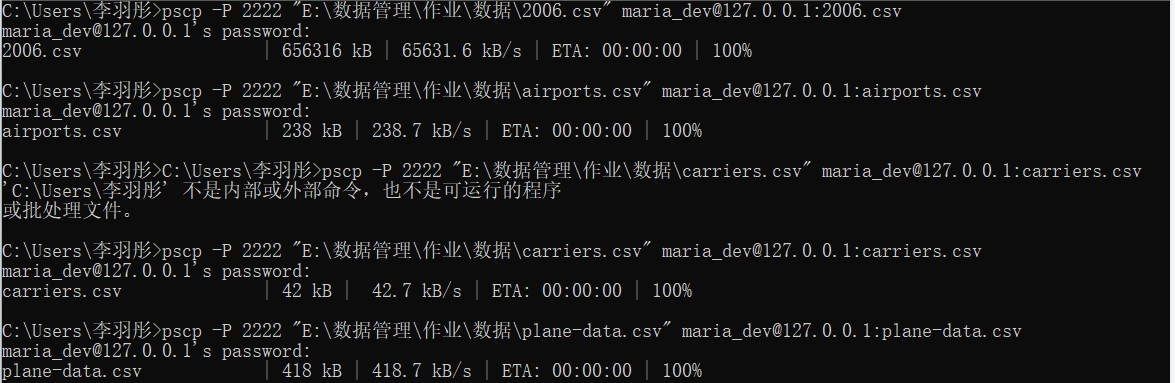

In [ ]:
from IPython.display import Image
Image("/content/1.jpg",width =900)

2. Upload data to hadoop (the following code is implemented in putty)

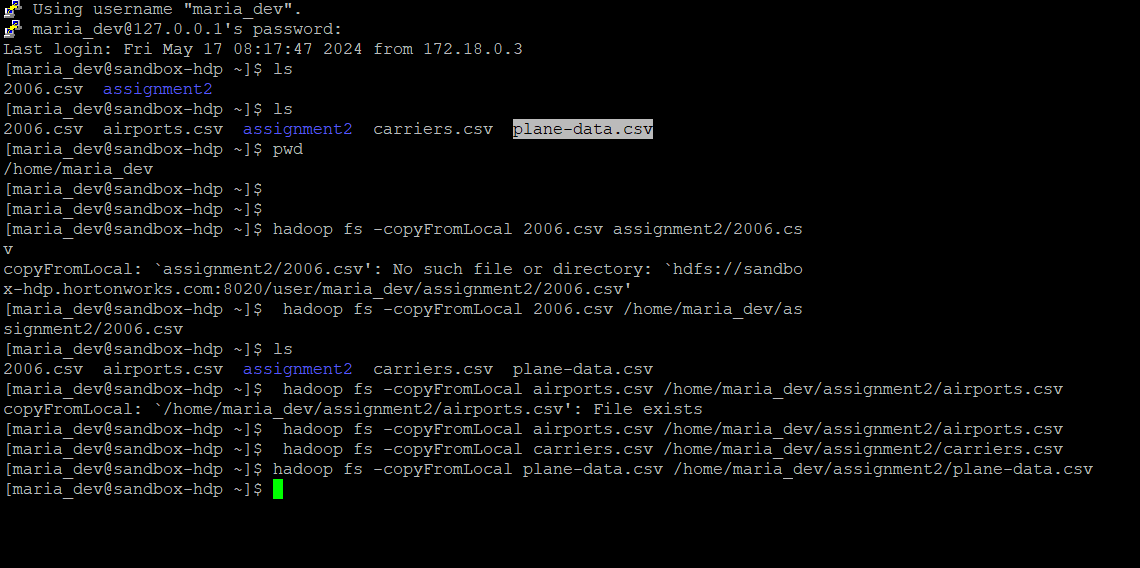

In [ ]:
Image("/content/22.png",width =900)

## **What are the optimal times of day, days of the week, and times of the year for minimizing flight delays?**  

For the first question, first we need to determine what 'flight delays' are. By observing the data set, we found that there are two variables that can be used to analyze this problem, one is arrdelay (arrival delay) and the other is depdelay (departure). Delay). In real life, there are situations where planes take off late but arrive early, and they take off late but arrive on time. From a passenger's perspective, whether arrival is delayed is their main concern. Therefore, we chose the variable arrdelay for this problem.

In order to make the analysis results more meaningful, two reference values are selected respectively. The first value is, 'average arrival delay time', the average arrival delay in minutes, and the second value is 'the proportion of arrival delay flights Percentage of total flights'.

Load the dataset in pig:

In [ ]:
flights = LOAD '/home/maria_dev/assignment2/2006.csv' USING PigStorage(',') AS (Year:int,Month:int,DayOfmonth:int,DayOfweek:int,DepTime:int,
    CrsDepTime:int,ArrTime:int,CrsArrtime:int,UniqueCarrier:chararray,FlightNum:int,TailNum:chararray,ActualElapsedTime:int,
    CrsElapsedTime:int,AirTime:int,ArrDelay:int,DepDelay:int,Origin:chararray,Dest:chararray,Distance:int,Taxiln:int,TaxiOut:int,
    Cancelled:int,CancellationCode:chararray,Diverted:int,CarrierDelay:int,WeatherDelay:int,NasDelay:int,SecurityDelay:int,LateAircraftDelay:int);

First of all, we need to analyze what time of year is best for flying. We can divide the 12 months of the year into four seasons, and divide the months by seasons. December to February is defined as winter, and March to May is defined as spring. June to September is defined as summer, and September to November is defined as autumn. Therefore, to find the most suitable time of year for flying, we need to find the season of the year with the shortest average flight delay time and the season with the lowest delay ratio.

In [ ]:
--Extract the information required for the first question
flights_delay = FOREACH flights GENERATE Month, DayOfmonth, DayOfweek,
    (CASE
        WHEN Month IN (12,1,2) THEN 'Winter'
        WHEN Month IN (3,4,5) THEN 'Spring'
        WHEN Month IN (6,7,8) THEN 'Summer'
        WHEN Month IN (9,10,11) THEN 'Autumn'
    END) AS season,
    (CASE
        WHEN ArrDelay IS NULL THEN 0 ELSE ArrDelay
    END) AS arrdelay;

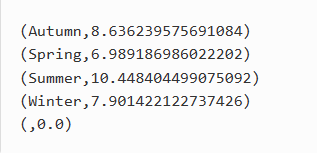

In [ ]:
Image("/content/季节平均延误.png",width =300)

According to the results, it can be seen that the season with the shortest average delay time in 2006 was the spring (March, April, and May) months, which was 6.9 minutes. The longest delays occur during the summer months (June, July and August).

Further analysis, observe the ‘percentage of delayed arrival flights to total flights’ in each season

In [ ]:
--Calculate average flight delays for each season
season_group = GROUP flights_delay BY season;
average_delays = FOREACH season_group GENERATE group AS season,
    AVG(flights_delay.arrdelay) AS average_delay;

In [ ]:
--Calculate the total number of flights per season
season_all = FOREACH season_group GENERATE group AS season, COUNT(flights_delay.arrdelay) AS total;

-- Calculate the number of delayed flights
season_delayed_flights = FILTER flights_delay BY arrdelay > 0;
season_group_delayed = GROUP season_delayed_flights BY season;
delayed_flights_count = FOREACH season_group_delayed GENERATE group AS season, COUNT(season_delayed_flights) AS delayed_flights_number;

--Combine two tables
delayed_flights_ratio = JOIN season_all BY season, delayed_flights_count BY season;
delayed_flights_percentage = FOREACH delayed_flights_ratio GENERATE season_all::season AS season,
    ((float)delayed_flights_count::delayed_flights_number / (float)season_all::total) * 100 AS delay_percentage;
DUMP average_delays_hour_sorted;

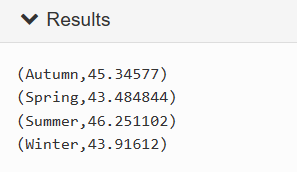

In [ ]:
Image("/content/季节延迟比例.png",width =300)

The results show that delayed flights accounted for 45.34577% in autumn, 43.484844% in autumn, 46.251102% in summer, and 43.91612% in winter.Judging from the proportion results, the probability of flight delays is lowest in spring.

**Visualize results （python）**

In [3]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
season1 = pd.read_csv('/content/season1.csv', header=None)
season2 = pd.read_csv('/content/season2.csv',header=None)

In [ ]:
season1= season1[season1[1] != 0]
season1=season1.rename(columns={0: 'season', 1: 'delay_time'})
season2=season2.rename(columns={0: 'season', 1: 'delay_time'})

In [ ]:
season1.head()

,season,delay_time
0,Autumn,8.636240
1,Spring,6.989187
2,Summer,10.448404
3,Winter,7.901422


In [ ]:
season2['delay_time'] =season2['delay_time']/100

season2.head()

,season,delay_time
0,Autumn,0.453458
1,Spring,0.434848
2,Summer,0.462511
3,Winter,0.439161


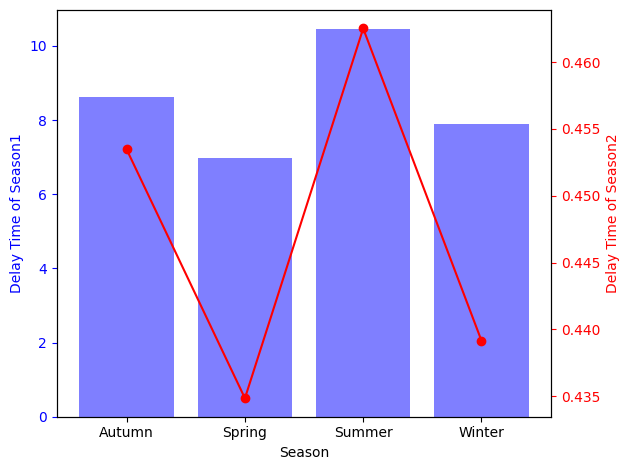

In [ ]:
#Create graphics
fig, ax1 = plt.subplots()
ax1.bar(season1['season'], season1['delay_time'], color='b', alpha=0.5, label='season1')
ax1.set_xlabel('Season')
ax1.set_ylabel('Delay Time of Season1', color='b')
ax1.tick_params('y', colors='b')

ax2 = ax1.twinx()
ax2.plot(season2['season'], season2['delay_time'], color='r', marker='o', label='season2')
ax2.set_ylabel('Delay Time of Season2', color='r')
ax2.tick_params('y', colors='r')

fig.tight_layout()
plt.show()

According to the 2006 flight information, it can be seen that the most suitable season of the year for flying is spring.

**Next we analyze by month to find the best month of the year for flying.**

In [ ]:
--Calculate average flight delays per month
month_group = GROUP flights_delay BY Month;
average_delays_month = FOREACH month_group GENERATE group AS Month,
    AVG(flights_delay.arrdelay) AS average_delay;

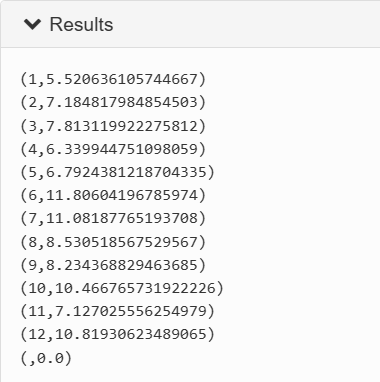

In [ ]:
Image("/content/月平均延误时间.png",width =300)

In [ ]:
--Calculate the total number of flights per month
month_all = FOREACH month_group GENERATE group AS month, COUNT(flights_delay.arrdelay) AS total;
-- Calculate the number of delayed flights
month_delayed_flights = FILTER flights_delay BY arrdelay > 0;
month_group_delayed = GROUP month_delayed_flights BY Month;
delayed_month_count = FOREACH month_group_delayed GENERATE group AS month, COUNT(month_delayed_flights) AS delayed_flights_number;

delayed_month_ratio = JOIN month_all BY month, delayed_month_count BY month;
delayed_month_percentage = FOREACH delayed_month_ratio GENERATE month_all::month AS month,
    ((float)delayed_month_count::delayed_flights_number / (float)month_all::total) * 100 AS delay_percentage;

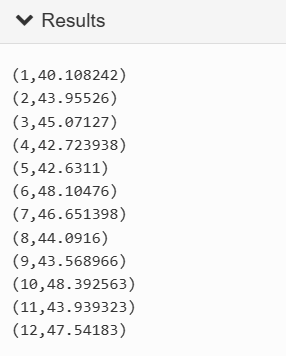

In [ ]:
Image("/content/月延迟比例.png",width =300)

The results show that the average delay time in January was 5.52, and the proportion of flight delays in January was 40.108242%.

**Data visualization (python)**

In [ ]:
month1 = pd.read_csv('/content/month1.csv', header=None)
month2 = pd.read_csv('/content/month2.csv',header=None)

month1=month1.rename(columns={0: 'month', 1: 'delay_time'})
month2=month2.rename(columns={0: 'month', 1: 'delay_time'})

In [ ]:
month1 = month1.dropna()
month1['month'] = month1['month'].astype(int)
month1

,month,delay_time
0,1,5.520636
1,2,7.184818
2,3,7.813120
3,4,6.339945
4,5,6.792438
5,6,11.806042
6,7,11.081878
7,8,8.530519
8,9,8.234369
9,10,10.466766


In [ ]:
month2['delay_time'] =month2['delay_time']/100

month2.head()

,month,delay_time
0,1,0.401082
1,2,0.439553
2,3,0.450713
3,4,0.427239
4,5,0.426311


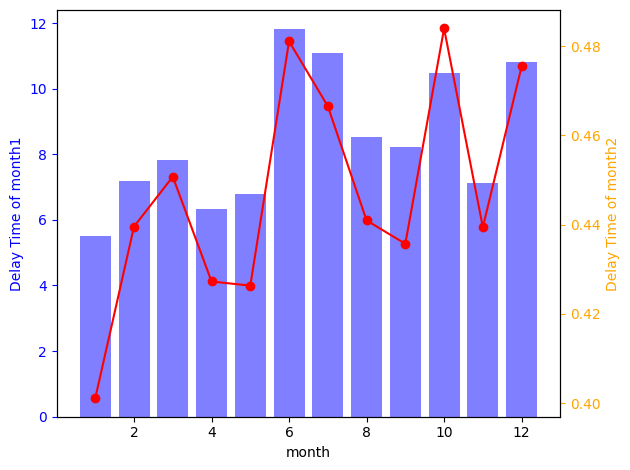

In [ ]:
#Create graphics
fig, ax1 = plt.subplots()
ax1.bar(month1['month'], month1['delay_time'], color='b', alpha=0.5, label='month1')
ax1.set_xlabel('month')
ax1.set_ylabel('Delay Time of month1', color='blue')
ax1.tick_params('y', colors='blue')

ax2 = ax1.twinx()
ax2.plot(month2['month'], month2['delay_time'], color='r', marker='o', label='month2')
ax2.set_ylabel('Delay Time of month2', color='orange')
ax2.tick_params('y', colors='orange')

fig.tight_layout()
plt.show()

You can directly observe the data for 12 months from the figure. Therefore, the best month of the year for flying is January in spring.

**The best day for flying (using pig for data processing)**

In [ ]:
--day of the week
day_group = GROUP flights_delay BY DayOfweek;
average_delays_day = FOREACH day_group GENERATE group AS DayOfweek,
    AVG(flights_delay.arrdelay) AS average_delay;

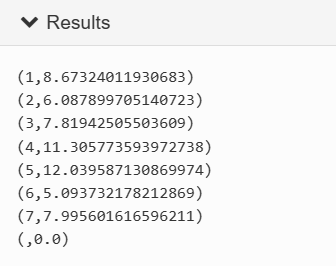

In [ ]:
Image("/content/一周7天平均延误时间.png",width =300)

In [ ]:
day_all = FOREACH day_group GENERATE group AS DayOfweek, COUNT(flights_delay.arrdelay) AS total;

day_delayed_flights = FILTER flights_delay BY arrdelay > 0;
day_group_delayed = GROUP day_delayed_flights BY DayOfweek;
delayed_day_count = FOREACH day_group_delayed GENERATE group AS DayOfweek, COUNT(day_delayed_flights) AS delayed_flights_number;

delayed_day_ratio = JOIN day_all BY DayOfweek, delayed_day_count BY DayOfweek;
delayed_day_percentage = FOREACH delayed_day_ratio GENERATE day_all::DayOfweek AS day,
    ((float)delayed_day_count::delayed_flights_number / (float)day_all::total) * 100 AS delay_percentage;

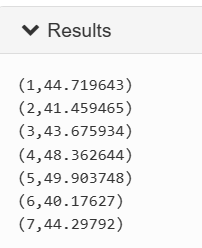

In [ ]:
Image("/content/一周7天延误比例.png",width =300)

In [ ]:
day1 = pd.read_csv('/content/1-7day1.csv', header=None)
day2 = pd.read_csv('/content/1-7day2.csv',header=None)

day1=day1.rename(columns={0: 'day', 1: 'delay_time'})
day2=day2.rename(columns={0: 'day', 1: 'delay_time'})

day1 = day1.dropna()
day1

,day,delay_time
0,1.0,8.673240
1,2.0,6.087900
2,3.0,7.819425
3,4.0,11.305774
4,5.0,12.039587
5,6.0,5.093732
6,7.0,7.995602


In [ ]:
day2['delay_time'] =day2['delay_time']/100

day2.head()

,day,delay_time
0,1,0.447196
1,2,0.414595
2,3,0.436759
3,4,0.483626
4,5,0.499037


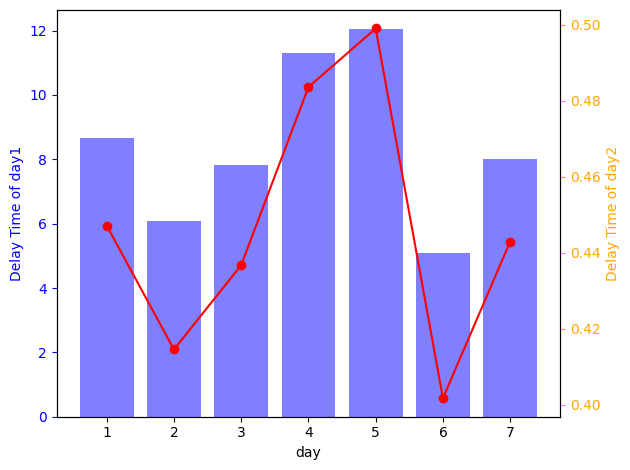

In [ ]:
fig, ax1 = plt.subplots()
# day1
ax1.bar(day1['day'], day1['delay_time'], color='b', alpha=0.5, label='day1')
ax1.set_xlabel('day')
ax1.set_ylabel('Delay Time of day1', color='blue')
ax1.tick_params('y', colors='blue')

# day2
ax2 = ax1.twinx()
ax2.plot(day2['day'], day2['delay_time'], color='r', marker='o', label='day2')
ax2.set_ylabel('Delay Time of day2', color='orange')
ax2.tick_params('y', colors='orange')

fig.tight_layout()
plt.show()

By observing the average arrival delay time for 7 days in a week, and the ‘percentage of arrival delayed flights to total flights’, it can be seen that Saturday is the day with the shortest delay time and the lowest delay ratio among the 7 days.

**The most suitable time period for flying (use pig for data processing)**

Divide the day into 24 hours and find the time period with the smallest average delay.

In [ ]:
--Calculate the time of day
--Extract hour part
flights_hour = FOREACH flights GENERATE (CrsDepTime / 100) AS hour, ArrDelay;
flights_hour_delay = FILTER flights_hour BY ArrDelay > 0;
hour_group = GROUP flights_hour_delay BY hour;

-- Calculate average delay time per hour
average_delays_hour = FOREACH hour_group GENERATE group AS hour, AVG(flights_hour_delay.ArrDelay) AS average_delay;

-- Sort by average delay time
average_delays_hour_sorted = ORDER average_delays_hour BY average_delay;

DUMP average_delays_hour_sorted;

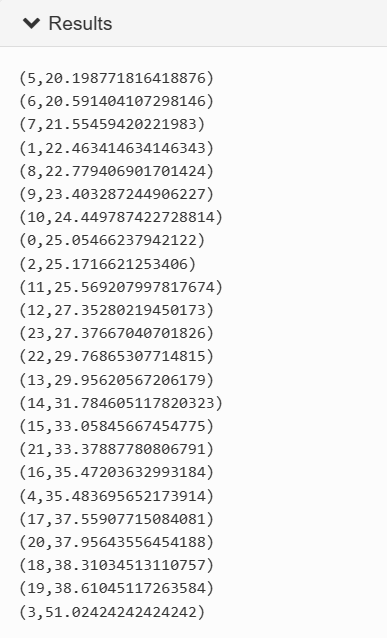

In [ ]:
Image("/content/一天24小时延误比例.png",width =500)

In [ ]:
hour1 = pd.read_csv('/content/hour1.csv', header=None)
hour1 = hour1.rename(columns={0: 'hour', 1: 'delay_time'})
hour1
hour1['hour'] = hour1['hour'].astype(int)
hour1.head()

,hour,delay_time
0,5,20.198772
1,6,20.591404
2,7,21.554594
3,1,22.463415
4,8,22.779407


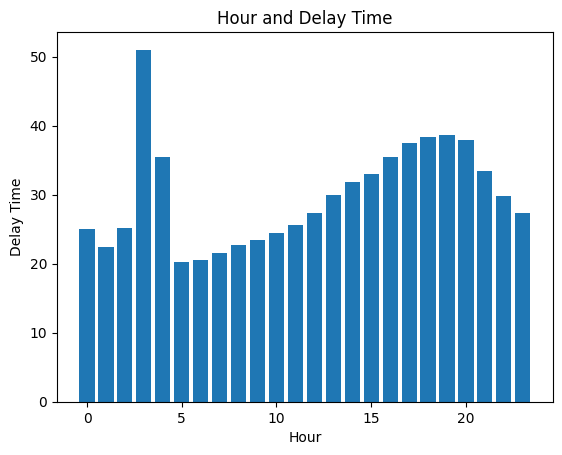

In [ ]:
plt.bar(hour1['hour'], hour1['delay_time'])
plt.xlabel('Hour')
plt.ylabel('Delay Time')
plt.title('Hour and Delay Time')
plt.show()

The results show that among the 24 hours a day, the average flight delay time was small at 5 a.m. and 6 a.m. in 2006.

**Conclusion:** By analyzing the flight data of the aircraft in 2006, the following conclusions can be drawn. The most suitable month for flying is January in winter, and the most suitable time for flying in the week is the time period between 5 and 6 o'clock in the morning on Tuesday. Because the average flight delay time is the smallest during this period, and the probability of delays is the lowest.

Therefore, as a passenger, you should choose flights during this time period when choosing to travel, which can reduce conflicts in your own itinerary due to flight delays.

## **What are the primary factors contributing to flight delays?**

In order to answer this question, we first need to find the delay causes that can be used in the data. There are 5 delay causes included in the data set, which are variables: WeatherDelay, CarrierDelay, NasDelay, SecurityDelay, LateAircraftDelay. These five variables record the delay time caused by this reason. Therefore, we can find the largest factor affecting delay by calculating the average delay time of these five variables.

In [ ]:
-- Analyze delays caused by weather
Weather_reason = FOREACH flights GENERATE WeatherDelay, (CASE WHEN ArrDelay IS NULL THEN 0 ELSE ArrDelay END) AS arrdelay;

-- Filter out data whose arrival delay time is less than or equal to 0
Weather_reason_data = FILTER Weather_reason BY arrdelay>=0;

-- Group
Weather_data = GROUP Weather_reason_data ALL;

-- Calculate average weather delays
delay_Weather_data = FOREACH Weather_data GENERATE AVG(Weather_reason_data.WeatherDelay) AS total;

DUMP delay_Weather_data;


-- Carrier delay
delay_Carrier_reason = FOREACH flights GENERATE CarrierDelay, (CASE WHEN ArrDelay IS NULL THEN 0 ELSE ArrDelay END) AS arrdelay;
delay_Carrier_data = FILTER delay_Carrier_reason BY arrdelay>=0;
Carrier_data = GROUP delay_Carrier_data ALL;
-- Calculate average carrier delay time
delay_CarrierDelay = FOREACH Carrier_data GENERATE AVG(delay_Carrier_data.CarrierDelay) AS total;
DUMP delay_CarrierDelay;

-- NasDelay
delay_NasDelay_reason = FOREACH flights GENERATE NasDelay, (CASE WHEN ArrDelay IS NULL THEN 0 ELSE ArrDelay END) AS arrdelay;
delay_NasDelay_data = FILTER delay_NasDelay_reason BY arrdelay>=0;
NasDelay_data = GROUP delay_NasDelay_data ALL;

-- Calculate average NasDelay delay time
delay_NasDelay = FOREACH NasDelay_data GENERATE AVG(delay_NasDelay_data.NasDelay) AS total;
DUMP delay_NasDelay;

-- SecurityDelay
delay_SecurityDelay_reason = FOREACH flights GENERATE SecurityDelay, (CASE WHEN ArrDelay IS NULL THEN 0 ELSE ArrDelay END) AS arrdelay;
delay_SecurityDelay_data = FILTER delay_SecurityDelay_reason BY arrdelay>=0;
SecurityDelay_data = GROUP delay_SecurityDelay_data ALL;

-- SecurityDelay delay time
delay_SecurityDelay = FOREACH SecurityDelay_data GENERATE AVG(delay_SecurityDelay_data.SecurityDelay) AS total;
DUMP delay_SecurityDelay;

-- LateAircraftDelay
delay_LateAircraftDelay_reason = FOREACH flights GENERATE LateAircraftDelay, (CASE WHEN ArrDelay IS NULL THEN 0 ELSE ArrDelay END) AS arrdelay;
delay_LateAircraftDelay_data = FILTER delay_LateAircraftDelay_reason BY arrdelay>=0;
LateAircraftDelay_data = GROUP delay_LateAircraftDelay_data ALL;

-- Calculate the average LateAircraftDelay time
delay_LateAircraftDelay = FOREACH LateAircraftDelay_data GENERATE AVG(delay_LateAircraftDelay_data.LateAircraftDelay) AS total;
DUMP delay_LateAircraftDelay;

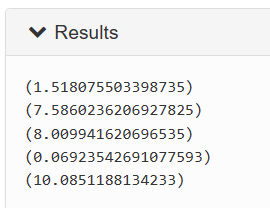

In [ ]:
Image("/content/影响最大的因素.png",width =500)

**Visualization in python**

In [ ]:
CarrierDelay = pd.read_csv('/content/CarrierDelay.csv', header=None)
LateAircraftDelay = pd.read_csv('/content/LateAircraftDelay.csv',header=None)
NasDelay = pd.read_csv('/content/NasDelay.csv',header=None)
SecurityDelay = pd.read_csv('/content/SecurityDelay.csv',header=None)
WeatherDelay = pd.read_csv('/content/WeatherDelay.csv',header=None)

In [ ]:
reason = pd.concat([CarrierDelay, LateAircraftDelay, NasDelay, SecurityDelay, WeatherDelay])
reason

,0,1
0,CarrierDelay,7.586024
0,LateAircraftDelay,10.085119
0,NasDelay,8.009942
0,SecurityDelay,0.069235
0,WeatherDelay,1.518076


In [ ]:
reason=reason.rename(columns={0: 'reason', 1: 'delay_time'})
reason

,reason,delay_time
0,CarrierDelay,7.586024
0,LateAircraftDelay,10.085119
0,NasDelay,8.009942
0,SecurityDelay,0.069235
0,WeatherDelay,1.518076


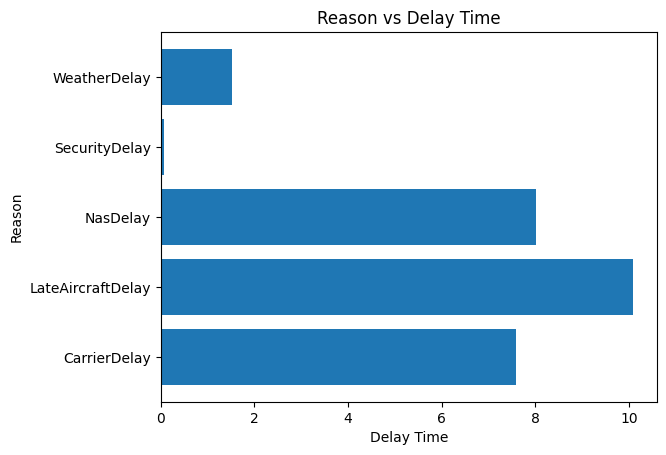

In [ ]:
plt.barh(reason['reason'], reason['delay_time'])
plt.xlabel('Delay Time')
plt.ylabel('Reason')
plt.title('Reason vs Delay Time')
plt.show()

**Conclusion:** The data of this result corresponds to WeatherDelay, CarrierDelay, NasDelay, SecurityDelay, LateAircraftDelay from top to bottom. It can be seen that the average delay time caused by SecurityDelay is the least, and the average delay time caused by LateAircraftDelay is longest. Therefore, the delay time caused by the delay of the previous flight is the biggest factor causing flight delays.

## **What factors predominantly lead to flight cancellations?**

In this data set, the variables that can be used to analyze this problem are Cancelled, CancellationCode. In the Cancelled column, 1 represents cancellation, so by filtering this column for values equal to 1, you can find canceled flights. A, B, C, and D in the CancellationCode column represent different reasons for cancellation. By grouping statistical reasons, you can find the reason for the most cancellations.

In [ ]:
cancell_reson = FOREACH flights GENERATE Cancelled, CancellationCode;

cancell_reson_data = FILTER cancell_reson BY Cancelled == 1;
cancell_reason_group = GROUP cancell_reson_data by CancellationCode;
cancell_reason_num = FOREACH cancell_reason_group GENERATE group AS CancellationCode, COUNT(cancell_reson_data.Cancelled) AS total;
DUMP cancell_reason_num;

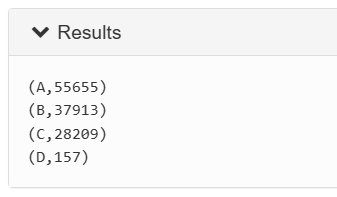

In [ ]:
Image("/content/被取消原因.png",width =500)

In [ ]:
reason_cancell= pd.read_csv('/content/reason.csv', header=None)
reason_cancell=reason.rename(columns={0: 'reason', 1: 'count'})

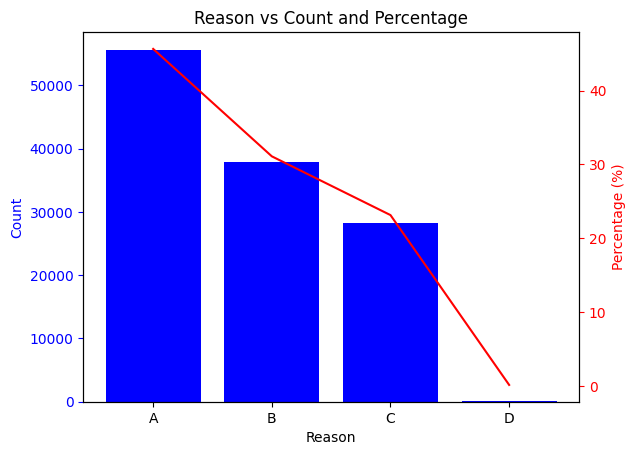

In [ ]:
# Calculate proportion
total = reason_cancell['count'].sum()
reason_cancell['percentage'] = reason_cancell['count'] / total * 100

# Create chart
fig, ax1 = plt.subplots()
ax1.bar(reason_cancell['reason'], reason_cancell['count'], color='b')
ax1.set_xlabel('Reason')
ax1.set_ylabel('Count', color='b')
ax1.tick_params('y', colors='b')


ax2 = ax1.twinx()
ax2.plot(reason_cancell['reason'], reason_cancell['percentage'], color='r')
ax2.set_ylabel('Percentage (%)', color='r')
ax2.tick_params('y', colors='r')

plt.title('Reason vs Count and Percentage')
plt.show()

**Conclusion:** It can be seen from the results that A is the biggest factor leading to flight cancellations.

## **Which flight experiences the most frequent and significant delays and cancellations?**

This issue mainly revolves around flights, delays and cancellations. Find these three variables in the data set, filter out the canceled and delayed flights, sort the data, and find the flight number with the highest number of cancellations and delays.

In [ ]:
flight_num = FOREACH flights GENERATE FlightNum, ArrDelay, Cancelled;

flight_num = FOREACH flights GENERATE FlightNum, ArrDelay, Cancelled;


--Filter out canceled flights

cancelled_flights = FILTER flight_num BY Cancelled != 0;

--Filter out flights with arrival delays
delayed_flights = FILTER flight_num BY ArrDelay > 0;

grouped_cancelled = GROUP cancelled_flights BY FlightNum;
count_cancelled = FOREACH grouped_cancelled GENERATE group AS FlightNum, COUNT(cancelled_flights) AS CancelledCount;

--Sort by number of cancellations
most_count_cancelled = ORDER count_cancelled BY CancelledCount DESC;

DUMP most_count_cancelled;

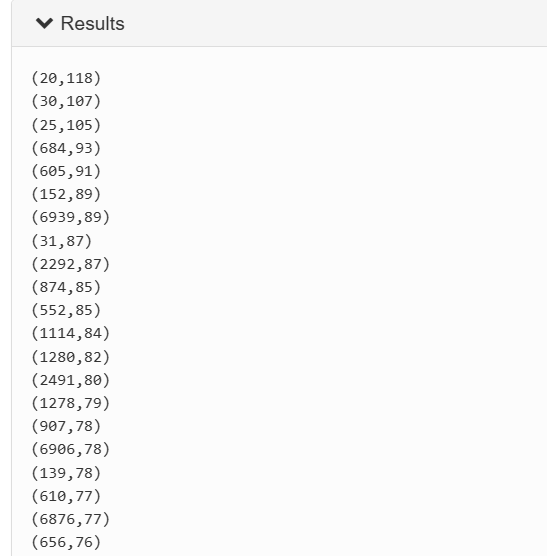

In [ ]:
Image("/content/取消次数排名.png",width =500)

In [ ]:
--Group and count delayed flights
grouped_delayed = GROUP delayed_flights BY FlightNum;
count_delayed = FOREACH grouped_delayed GENERATE group AS FlightNum, COUNT(delayed_flights) AS delayedCount;
most_count_delayed = ORDER count_delayed BY delayedCount DESC;

DUMP most_count_delayed;

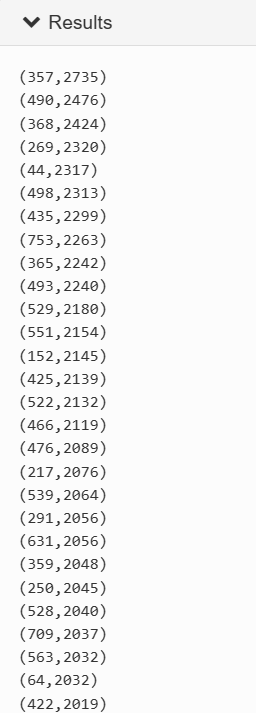

In [ ]:
Image("/content/延误次数排名.png",width =300)

In [4]:
cancell_num = pd.read_csv('/content/most_count_cancelled.csv', header=None)
delayed_num = pd.read_csv('/content/most_count_delayed.csv', header=None)

In [5]:
most_cancell_num=cancell_num.head(10)
most_delayed_num=delayed_num.head(10)

most_cancell_num=most_cancell_num.rename(columns={0: 'flightnum', 1: 'count'})
most_delayed_num=most_delayed_num.rename(columns={0: 'flightnum', 1: 'time'})

In [6]:
most_cancell_num

,flightnum,count
0,20,118
1,30,107
2,25,105
3,684,93
4,605,91
5,152,89
6,6939,89
7,31,87
8,2292,87
9,874,85


In [7]:
most_delayed_num

,flightnum,time
0,357,2735
1,490,2476
2,368,2424
3,269,2320
4,44,2317
5,498,2313
6,435,2299
7,753,2263
8,365,2242
9,493,2240


According to the data, flight number 20 has the highest number of cancellations. Flight number 357 has the highest number of delays.